# Praca domowa 7
#### Mateusz Grzyb

Wczytam kilka potrzebnych pakietów.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize

import numpy as np

Następnie wczytam obraz do kompresji stratnej. Jest to znana scena, pochodząca z równie znanego filmu :)

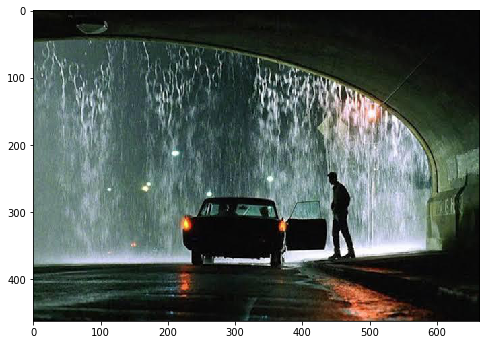

In [2]:
image = mpimg.imread('./neo.png')
fig = plt.figure(figsize=(8, 8))
plt.imshow(image);

Obraz reprezentowany jest przez trójwymiarową macierz. Jego wymiar to 664x462 pikseli, do tego 3 kanały koloru (RGB).

In [3]:
image.shape

(462, 664, 3)

Elementy macierzy zajmują 3681216 bajtów pamięci.

> **nbytes**
>
> Total bytes consumed by the elements of the array.
>
> https://numpy.org/doc/stable/reference/generated/numpy.ndarray.nbytes.html

In [4]:
image.nbytes

3681216

Pora na kompresję. W tym celu przygotuję specjalną funkcję.

In [5]:
def matrix(image, range_):
    components = []
    image_reproductions = []
    explained_variances = []
    image_sizes = []
    
    for i in range_:
        components.append(i)
        
        image_copy = image.copy()
        image_copy = np.array(image_copy).reshape(image.shape[0]*image.shape[2], image.shape[1])
        
        pca = PCA(i)
        
        compressed_image = pca.fit_transform(image_copy)
        
        explained_variances.append(sum(pca.explained_variance_ratio_))
        image_sizes.append(compressed_image.nbytes)
        
        image_reproduction = pca.inverse_transform(compressed_image)
        image_reproduction = image_reproduction.reshape(image.shape[0], image.shape[1], image.shape[2])
        
        image_reproduction = image_reproduction.clip(0, 1)
        
        image_reproductions.append(image_reproduction)
    
    return components, image_reproductions, explained_variances, image_sizes

Wywołam przygotowaną funkcję na wczytanym wcześniej obrazie.

In [6]:
components, image_reproductions, explained_variances, image_sizes = matrix(image, range(1, 401))

Teraz możemy spojrzeć na powstałe reprodukcje oraz efektywność kompresji.

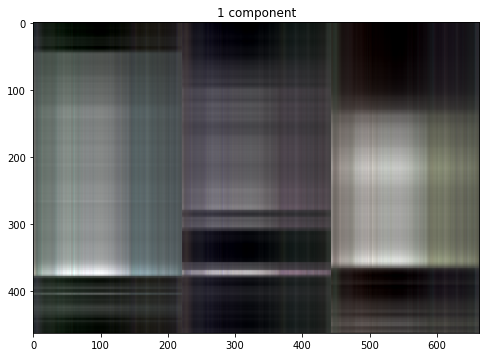

In [7]:
fig = plt.figure(figsize=(8, 8))
plt.imshow(image_reproductions[0])
plt.title('1 component');

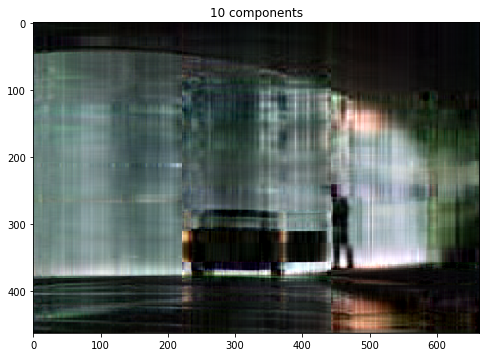

In [8]:
fig = plt.figure(figsize=(8, 8))
plt.imshow(image_reproductions[9])
plt.title('10 components');

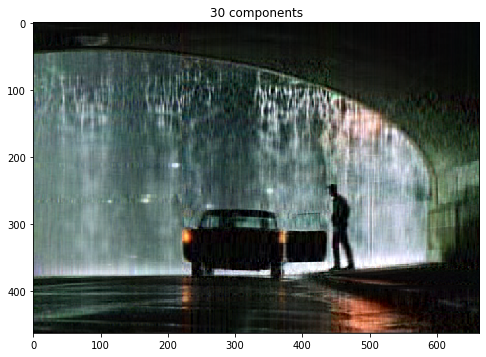

In [9]:
fig = plt.figure(figsize=(8, 8))
plt.imshow(image_reproductions[29])
plt.title('30 components');

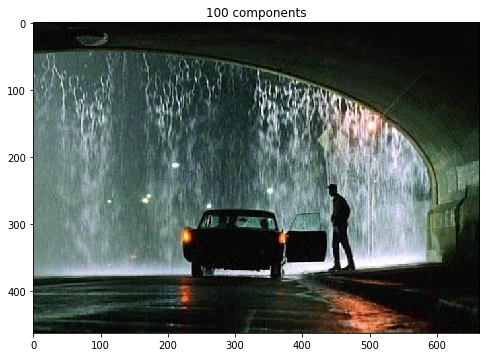

In [10]:
fig = plt.figure(figsize=(8, 8))
plt.imshow(image_reproductions[99])
plt.title('100 components');

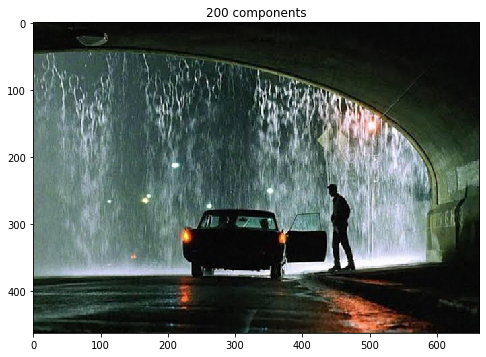

In [11]:
fig = plt.figure(figsize=(8, 8))
plt.imshow(image_reproductions[199])
plt.title('200 components');

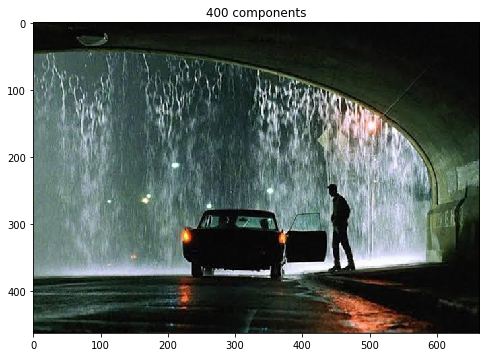

In [12]:
fig = plt.figure(figsize=(8, 8))
plt.imshow(image_reproductions[399])
plt.title('400 components');

Przy 100 komponentach jakość jest zadowalająca, a rozmiar to tylko 15,06% oryginalnego rozmiaru.

In [34]:
round((image_sizes[99]/image.nbytes)*100, 2)

15.06


Spójrzmy jeszcze na wykresy objaśnianej wariancji i rozmiaru.

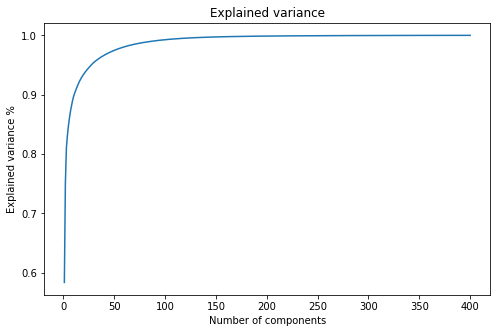

In [13]:
fig = plt.figure(figsize=(8, 5))
plt.plot(components, explained_variances)
plt.xlabel('Number of components')
plt.ylabel('Explained variance %')
plt.title('Explained variance');

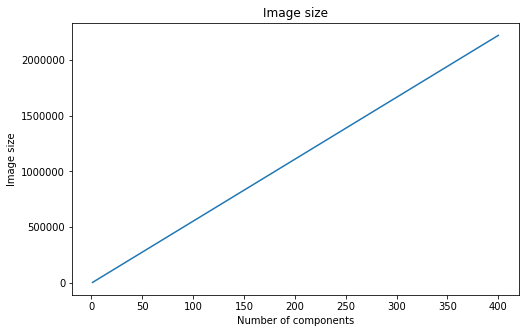

In [14]:
fig = plt.figure(figsize=(8, 5))
plt.plot(components, image_sizes)
plt.xlabel('Number of components')
plt.ylabel('Image size')
plt.title('Image size');

Jak widać wzrost liczby komponentów wiąże się ze zwiększoną wariancją objaśnianą (jakością obrazu), ale także ze zwiększonym rozmiarem. Na naszą korzyść działa jednak fakt, że rozmiar rośnie w sposób liniowy, a przyrost objaśnianej wariancji (jakości obrazu) początkowo "skacze" do góry.

Efekty kompresji przedstawić można również w postaci animacji (1-100 komponentów).

In [24]:
import imageio
converted_image_reproductions = image_reproductions.copy()
for i in range(len(converted_image_reproductions)):
    converted_image_reproductions[i] = converted_image_reproductions[i] * 255
    converted_image_reproductions[i] = converted_image_reproductions[i].astype(np.uint8)
imageio.mimsave('./neo.gif', converted_image_reproductions[0:99], duration=1/20)

![](./neo.gif)

### Zadanie dodatkowe

Najpierw wczytam dane.

In [117]:
import pandas as pd
import seaborn as sns
data = pd.read_table('./../../signals.tsv')
data

,time,signal1,signal2,signal3,signal4
0,0,0.493428,0.078710,-1.314636,1.193460
1,1,0.524618,0.791259,-1.321386,-0.075256
2,2,-0.024396,1.064251,-1.582284,0.785229
3,3,0.219586,1.007421,-1.481651,0.193773
4,4,0.426865,0.943133,-1.521795,-0.433458
...,...,...,...,...,...
9995,9995,-0.448773,-1.111182,1.695837,-0.249654
9996,9996,-1.017297,-1.054893,1.696765,0.547200
9997,9997,-0.189845,-0.915049,1.544527,0.000046
9998,9998,-0.563954,-0.785451,1.825540,-0.775807


Przyjrzymy się teraz poszczególnym sygnałom oraz macierzy korelacji.

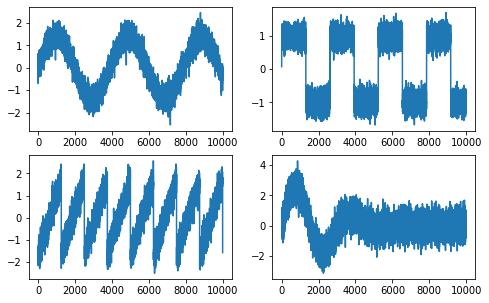

In [85]:
fig, ax = plt.subplots(2, 2, figsize=(8, 5))
ax[0, 0].plot(data.time, data.signal1)
ax[0, 1].plot(data.time, data.signal2)
ax[1, 0].plot(data.time, data.signal3)
ax[1, 1].plot(data.time, data.signal4);

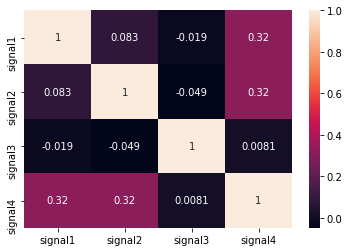

In [120]:
sns.heatmap(data.iloc[:, 1:5].corr(), annot=True);

Sygnał 4 jest jedynym sygnałem nieokresowym. Ponadto jest on widocznie skorelowany z sygnałami 1 i 2.

Zastosuję teraz Independent Component Analysis.

In [114]:
from sklearn.decomposition import FastICA
ica = FastICA(n_components=4, random_state=0)
transformed_data = ica.fit_transform(data.iloc[:, 1:5].values)
transformed_data = pd.DataFrame({'time': data.time,
                                 'signal1': transformed_data.T[0], 'signal2': transformed_data.T[2], 'signal3': transformed_data.T[3], 'signal4': transformed_data.T[1]})

Przyjrzymy się wynikom transformacji oraz nowej macierzy korelacji.

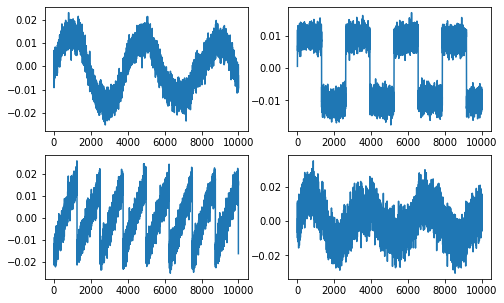

In [115]:
fig, ax = plt.subplots(2, 2, figsize=(8, 5))
ax[0, 0].plot(transformed_data.time, transformed_data.signal1)
ax[0, 1].plot(transformed_data.time, transformed_data.signal2)
ax[1, 0].plot(transformed_data.time, transformed_data.signal3)
ax[1, 1].plot(transformed_data.time, transformed_data.signal4);

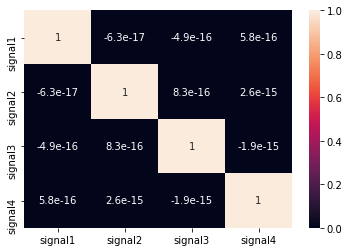

In [121]:
sns.heatmap(transformed_data.iloc[:, 1:5].corr(), annot=True);

Jak widać sygnał 4 znacznie się zmienił, jest teraz okresowy. Sygnały przestały być skorelowane.